In [2]:
!pip install lightgbm

     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     ------------ --------------------------- 0.5/1.5 MB 9.4 MB/s eta 0:00:01
     ------------------------------------ --- 1.3/1.5 MB 14.1 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 10.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\Aryan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

In [5]:
try:
    print ("\nLoading the data")
    train_df = pd.read_csv("C:/Users/Aryan/Downloads/Quant_Challenge_2025/train.csv")
    test_df = pd.read_csv("C:/Users/Aryan/Downloads/Quant_Challenge_2025/test.csv")
    print("data loaded")
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()


Loading the data
data loaded


<Figure size 2000x2000 with 0 Axes>

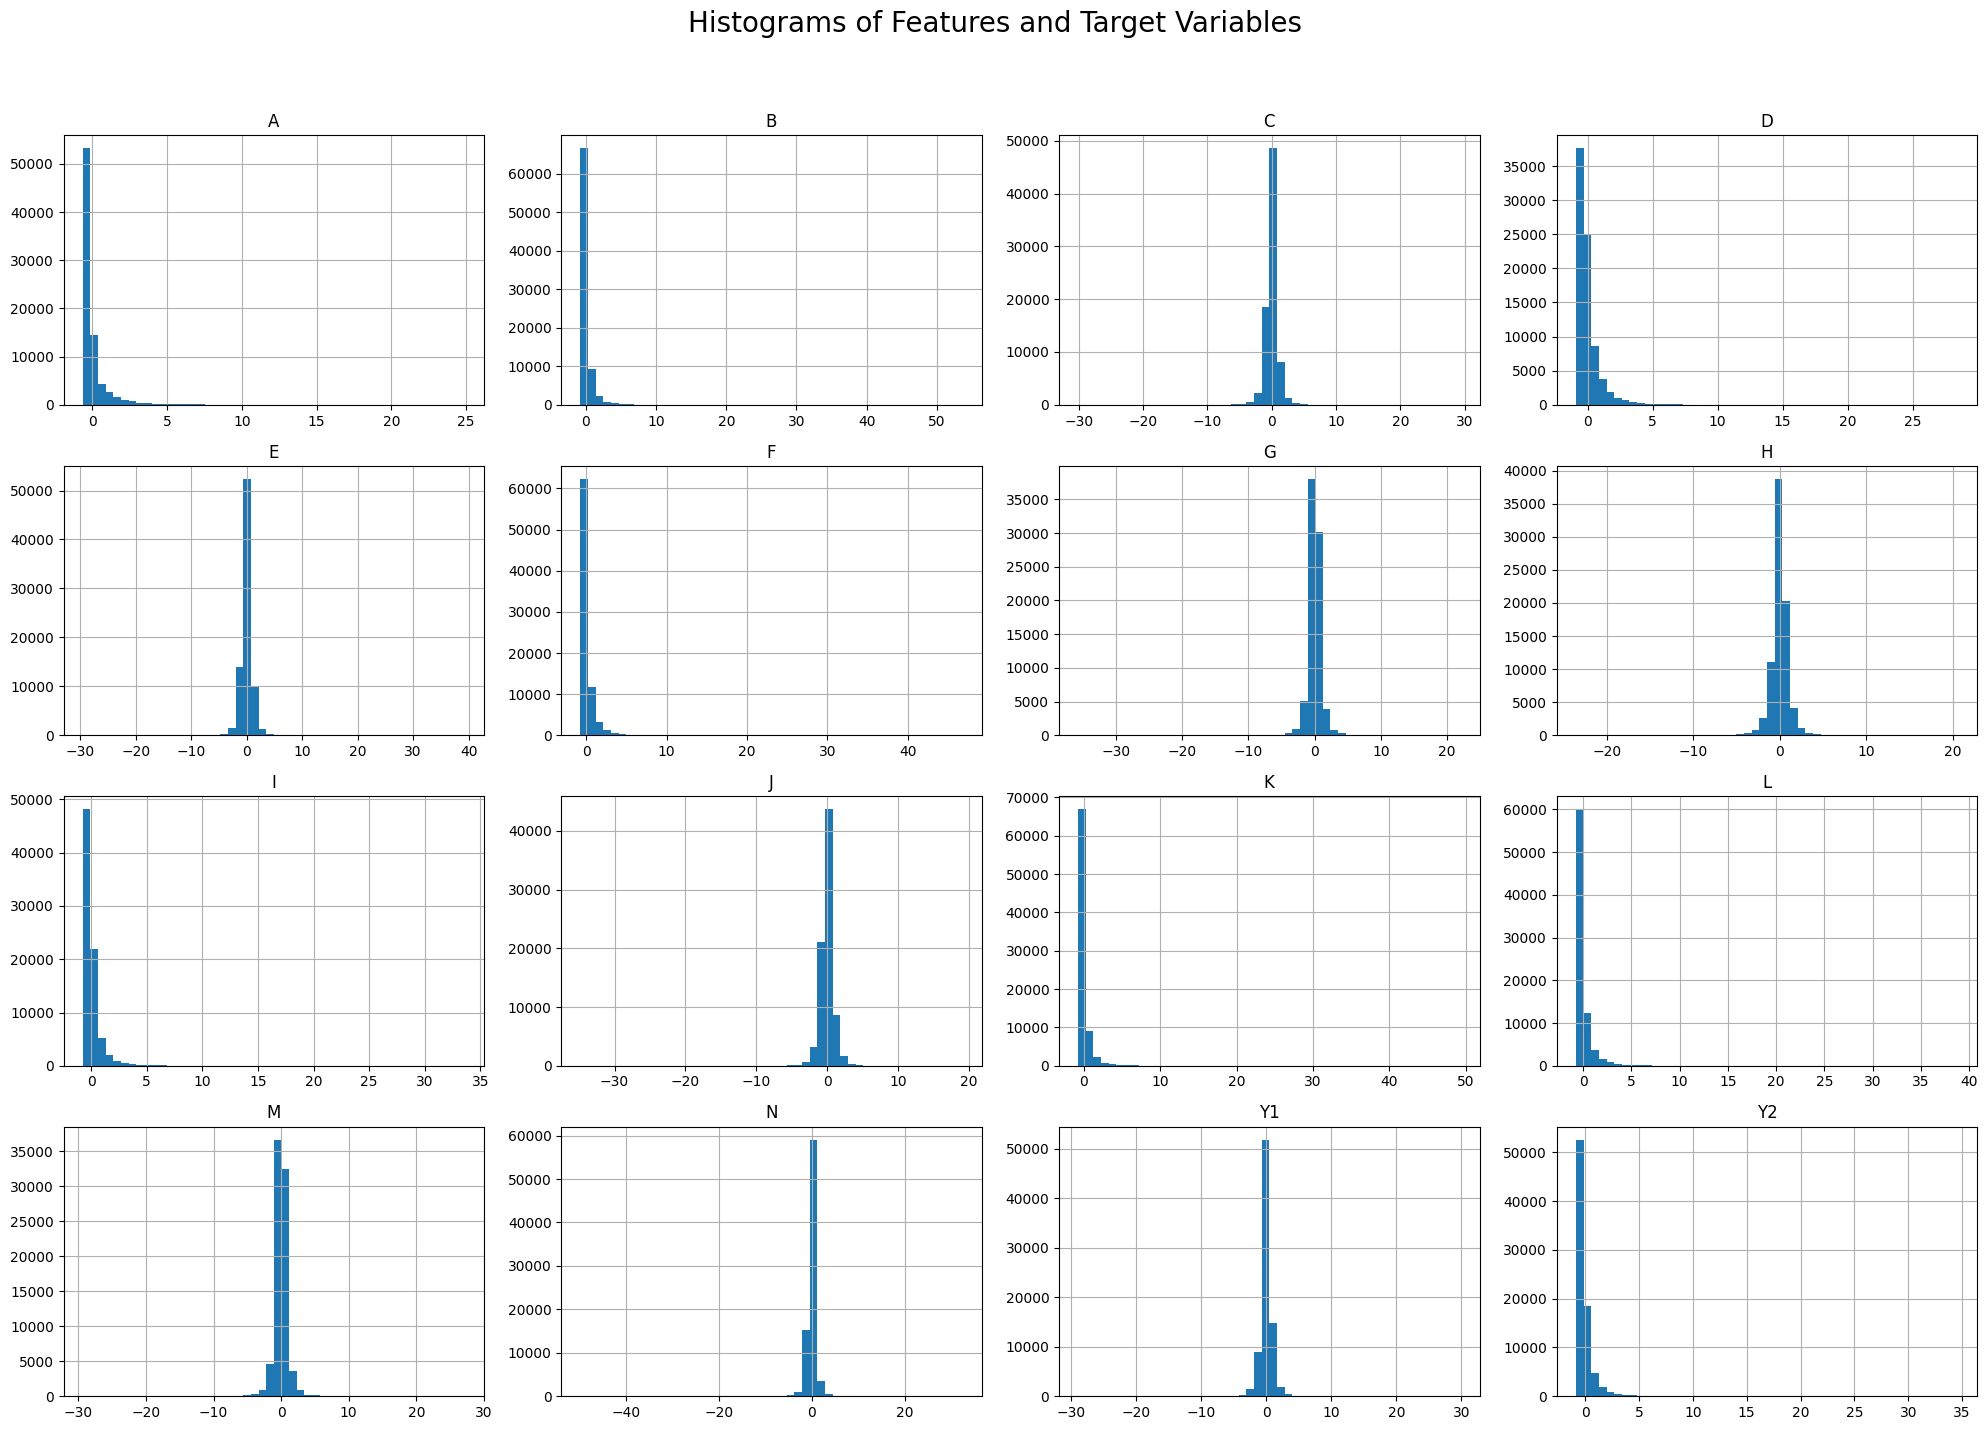

In [8]:
plt.figure(figsize=(20,20))
train_df.drop('time', axis=1).hist(bins=50, figsize=(20,15))
plt.suptitle('Histograms of Features and Target Variables', size=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('histograms.png')

plt.show()

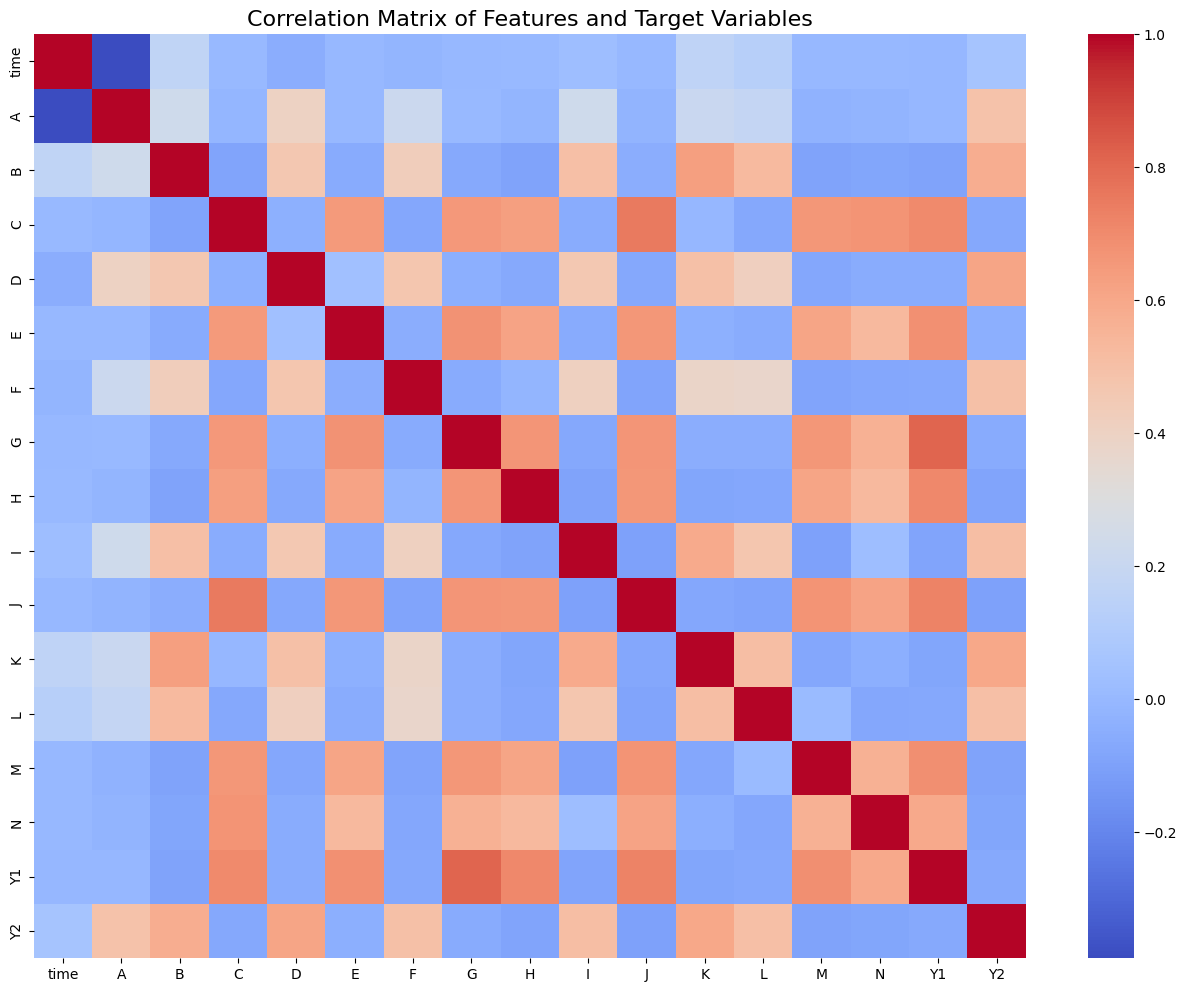

In [9]:
plt.figure(figsize=(16, 12))
corr_matrix = train_df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Features and Target Variables', size=16)
plt.savefig('correlation_heatmap.png')
plt.show()

In [17]:
#feature engineering

combined_df = pd.concat([train_df.drop(['Y1', 'Y2'], axis=1), test_df], ignore_index=True)

features = [col for col in train_df.columns if col not in ['time', 'Y1', 'Y2']]
WINDOW_SIZE = 10 

for feature in features:
    combined_df[f'{feature}_lag1'] = combined_df[feature].shift(1)
    combined_df[f'{feature}_rolling_mean{WINDOW_SIZE}'] = combined_df[feature].rolling(window=WINDOW_SIZE).mean()



train_processed_df = combined_df.iloc[:len(train_df)].copy()
test_processed_df = combined_df.iloc[len(train_df):].copy()

train_processed_df['Y1'] = train_df['Y1']
train_processed_df['Y2'] = train_df['Y2']

print(f"Shape before handling NaNs: {train_processed_df.shape}")
train_processed_df.bfill(inplace=True)
train_processed_df.ffill(inplace=True)
print(f"Shape after filling NaNs: {train_processed_df.shape}")

Shape before handling NaNs: (80000, 46)
Shape after filling NaNs: (80000, 46)


In [18]:
#Model Training

features_to_use = [col for col in train_processed_df.columns if col not in ['id', 'time', 'Y1', 'Y2']]
X_train = train_processed_df[features_to_use]
y1_train = train_processed_df['Y1']
y2_train = train_processed_df['Y2']

X_test = test_processed_df[features_to_use]
X_test.bfill(inplace=True)
X_test.ffill(inplace=True)

#LGB Params
lgb_params = {
    'objective': 'regression_l1',
    'metric': 'rmse',
    'n_estimators': 1500,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 40,
    'verbose': -1,
    'n_jobs': -1
}

#Train for Y1
model_y1_lgb = lgb.LGBMRegressor(**lgb_params)
model_y1_lgb.fit(X_train, y1_train)
predictions_y1_lgb = model_y1_lgb.predict(X_test)

#Train for Y2
model_y2_lgb = lgb.LGBMRegressor(**lgb_params)
model_y2_lgb.fit(X_train, y2_train)
predictions_y2_lgb = model_y2_lgb.predict(X_test)

In [19]:
submission_df = pd.DataFrame({'id': test_df['id'], 'Y1': predictions_y1_lgb, 'Y2': predictions_y2_lgb})
submission_df.to_csv('submission_lightgbm.csv', index=False)

print("\n✅ Success! Submission file 'submission_lightgbm.csv' created.")


✅ Success! Submission file 'submission_lightgbm.csv' created.
